In [5]:
from msmbuilder.dataset import dataset
xyz = dataset('/media/scottzhuang/data/MD/msm' + "/*.xtc",
              topology='/media/scottzhuang/data/MD/msm/4NPQ_pH70_md5.pdb',
              stride=1)
print("{} trajectories".format(len(xyz)))
# msmbuilder does not keep track of units! You must keep track of your
# data's timestep
to_ns = 10
print("with length {} ns".format(set(len(x)*to_ns for x in xyz)))

56 trajectories
with length {770, 1030, 1040, 790, 920, 1050, 540, 800, 930, 1060, 550, 680, 810, 1070, 820, 1590, 950, 830, 1470, 960, 1090, 1100, 590, 720, 980, 600, 990, 1120, 870, 1000, 620, 750, 880, 1010, 890} ns


In [6]:
from msmbuilder.featurizer import DihedralFeaturizer
featurizer = DihedralFeaturizer(types=['phi', 'psi'])
diheds = xyz.fit_transform_with(featurizer, '2diheds/', fmt='dir-npy')

print(xyz[0].xyz.shape)
print(diheds[0].shape)

/home/scottzhuang/anaconda3/envs/deepchem/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/scottzhuang/anaconda3/envs/deepchem/lib/python3.5/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


(110, 420, 3)
(110, 416)


In [7]:
from msmbuilder.preprocessing import RobustScaler
scaler = RobustScaler()
scaled_diheds = diheds.fit_transform_with(scaler, 'scaled_diheds/', fmt='dir-npy')

print(diheds[0].shape)
print(scaled_diheds[0].shape)

(110, 416)
(110, 416)


In [12]:
from msmbuilder.decomposition import tICA
tica_model = tICA(lag_time=2, n_components=4)
# fit and transform can be done in seperate steps:
tica_model = scaled_diheds.fit_with(tica_model)
tica_trajs = scaled_diheds.transform_with(tica_model, 'ticas/', fmt='dir-npy')

print(diheds[0].shape)
print(tica_trajs[0].shape)

/home/scottzhuang/anaconda3/envs/deepchem/lib/python3.5/site-packages/msmbuilder/decomposition/tica.py:405: UserWarning: The number of features (416) is greater than the length of the data (110). The covariance matrix is not guaranteed to be positive definite.
  warnings.warn("The number of features (%d) is greater than the length of the data (%d). The covariance matrix is not guaranteed to be positive definite." % (X.shape[1], X.shape[0]))
/home/scottzhuang/anaconda3/envs/deepchem/lib/python3.5/site-packages/msmbuilder/decomposition/tica.py:405: UserWarning: The number of features (416) is greater than the length of the data (107). The covariance matrix is not guaranteed to be positive definite.
  warnings.warn("The number of features (%d) is greater than the length of the data (%d). The covariance matrix is not guaranteed to be positive definite." % (X.shape[1], X.shape[0]))
/home/scottzhuang/anaconda3/envs/deepchem/lib/python3.5/site-packages/msmbuilder/decomposition/tica.py:405: Us

(110, 416)
(110, 4)


/home/scottzhuang/anaconda3/envs/deepchem/lib/python3.5/site-packages/msmbuilder/decomposition/tica.py:405: UserWarning: The number of features (416) is greater than the length of the data (87). The covariance matrix is not guaranteed to be positive definite.
  warnings.warn("The number of features (%d) is greater than the length of the data (%d). The covariance matrix is not guaranteed to be positive definite." % (X.shape[1], X.shape[0]))
/home/scottzhuang/anaconda3/envs/deepchem/lib/python3.5/site-packages/msmbuilder/decomposition/tica.py:405: UserWarning: The number of features (416) is greater than the length of the data (62). The covariance matrix is not guaranteed to be positive definite.
  warnings.warn("The number of features (%d) is greater than the length of the data (%d). The covariance matrix is not guaranteed to be positive definite." % (X.shape[1], X.shape[0]))
/home/scottzhuang/anaconda3/envs/deepchem/lib/python3.5/site-packages/msmbuilder/decomposition/tica.py:405: User

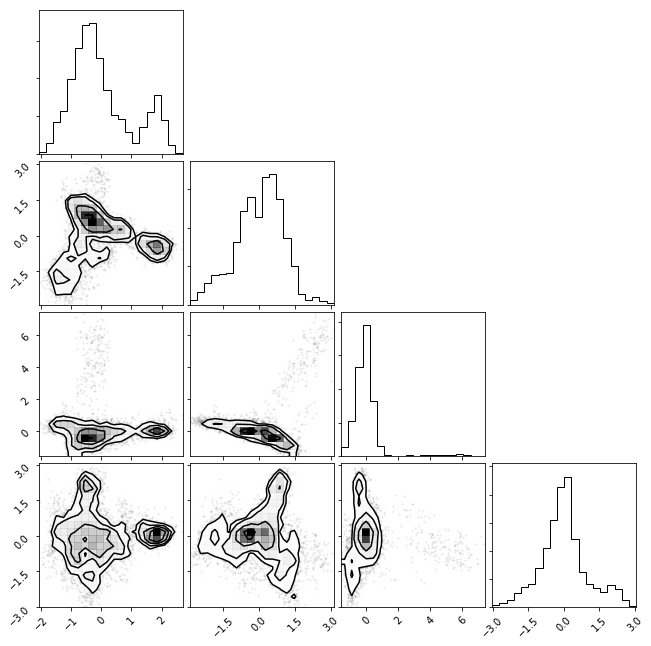

In [13]:
%matplotlib inline
import msmexplorer as msme
import numpy as np
txx = np.concatenate(tica_trajs)
_ = msme.plot_histogram(txx)

In [15]:
from msmbuilder.cluster import MiniBatchKMeans
clusterer = MiniBatchKMeans(n_clusters=100, random_state=42)
clustered_trajs = tica_trajs.fit_transform_with(
    clusterer, 'kmeans/', fmt='dir-npy'
)

print(tica_trajs[0].shape)
print(clustered_trajs[0].shape)

(110, 4)
(110,)


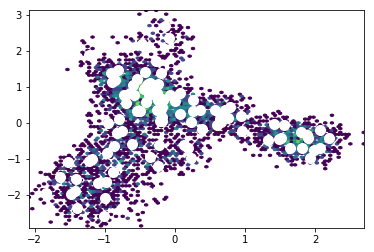

In [16]:
from matplotlib import pyplot as plt
plt.hexbin(txx[:,0], txx[:,1], bins='log', mincnt=1, cmap='viridis')
plt.scatter(clusterer.cluster_centers_[:,0],
            clusterer.cluster_centers_[:,1], 
            s=100, c='w')

In [17]:
from msmbuilder.msm import MarkovStateModel
from msmbuilder.utils import dump
msm = MarkovStateModel(lag_time=2, n_timescales=20)
msm.fit(clustered_trajs)

MSM contains 1 strongly connected component above weight=0.50. Component 0 selected, with population 100.000000%


MarkovStateModel(ergodic_cutoff='on', lag_time=2, n_timescales=20,
         prior_counts=0, reversible_type='mle', sliding_window=True,
         verbose=True)

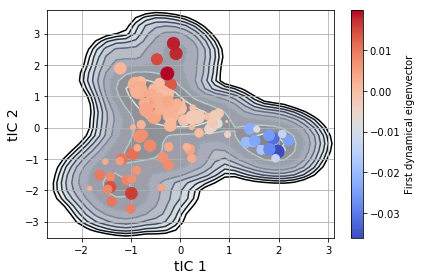

In [18]:
assignments = clusterer.partial_transform(txx)
assignments = msm.partial_transform(assignments)
msme.plot_free_energy(txx, obs=(0, 1), n_samples=10000,
                      pi=msm.populations_[assignments],
                      xlabel='tIC 1', ylabel='tIC 2')
plt.scatter(clusterer.cluster_centers_[msm.state_labels_, 0],
            clusterer.cluster_centers_[msm.state_labels_, 1],
            s=1e4 * msm.populations_,       # size by population
            c=msm.left_eigenvectors_[:, 1], # color by eigenvector
            cmap="coolwarm",
            zorder=3) 
plt.colorbar(label='First dynamical eigenvector')
plt.tight_layout()

In [19]:
msm.timescales_

array([ 130.3519812 ,  112.34712879,   87.92560809,   51.26045696,
         34.93347732,   31.5387223 ,   22.63065025,   15.62280573,
         14.55405973,   12.42066419,   10.67850887,   10.14090488,
          8.49736054,    7.02985936,    6.70539571,    6.10685831,
          5.58580619,    5.43632765,    4.81750298,    4.48631786])

/home/scottzhuang/anaconda3/envs/deepchem/lib/python3.5/site-packages/msmbuilder/msm/msm.py:567: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(sigma2)


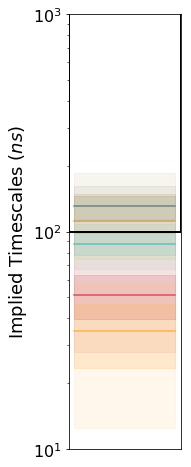

In [20]:
msme.plot_timescales(msm, n_timescales=5,
                     ylabel='Implied Timescales ($ns$)')

In [21]:
from msmbuilder.lumping import PCCAPlus
pcca = PCCAPlus.from_msm(msm, n_macrostates=4)
macro_trajs = pcca.transform(clustered_trajs)

Optimization terminated successfully.
         Current function value: -3.861197
         Iterations: 14
         Function evaluations: 135


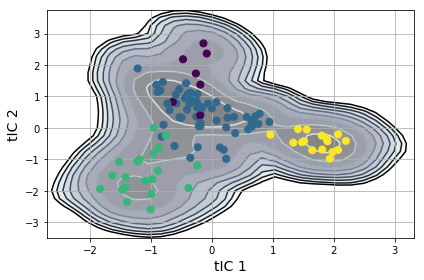

In [22]:
msme.plot_free_energy(txx, obs=(0, 1), n_samples=10000,
                      pi=msm.populations_[assignments],
                      xlabel='tIC 1', ylabel='tIC 2')
plt.scatter(clusterer.cluster_centers_[msm.state_labels_, 0],
            clusterer.cluster_centers_[msm.state_labels_, 1],
            s=50,
            c=pcca.microstate_mapping_,
            zorder=3
           )
plt.tight_layout()

In [24]:
#Importing all the modules
#msmbuilder imports 
from msmbuilder.dataset import dataset
from msmbuilder.featurizer import ContactFeaturizer
from msmbuilder.decomposition import tICA
from msmbuilder.cluster import MiniBatchKMeans
from msmbuilder.msm import ContinuousTimeMSM
from msmbuilder.utils import verbosedump,verboseload

#other imports
import os,glob
import numpy as np
import mdtraj as md
import pandas as pd 
import pickle

In [25]:
verbosedump(tica_model,"tica_mdl.pkl")

Saving "tica_mdl.pkl"... (<class 'msmbuilder.decomposition.tica.tICA'>)


In [26]:
import pandas as pd 
import mdtraj as md 
from msmbuilder.utils import load
from msmbuilder.featurizer import ContactFeaturizer
from tica_metadynamics.plumed_writer import render_tica_plumed_file

#python imports
import os,glob
import numpy as np
import pickle

In [39]:
feat =ContactFeaturizer([[0,3],[1,5]], scheme='ca')

In [40]:
df1 = pd.DataFrame(feat.describe_features(top))

In [41]:
print(df1)

     atominds featuregroup featurizer otherinfo  resids    resnames  resseqs
0  [[0], [3]]           ca    Contact        20  [0, 3]  [VAL, PRO]   [5, 8]
1  [[1], [5]]           ca    Contact        20  [1, 5]  [SER, PRO]  [6, 10]


In [43]:
output  = render_tica_plumed_file(tica_mdl= tica_model, df= df1, n_tics= 2, multiple_tics=None)

KeyError: 'vde_mdl'